### Librerias

In [221]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
# Modulos de scikit learn
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import learning_curve

## Carga de datos

La base de datos _California Housing Prices_ contiene datos sobre el precio de casas en California, junto con la información de la casa como número de pisos, número de cuartos, etc. En este trabajo, se va a realizar un modelo de árboles de decisión aplicado en regresión para predecir el precio de casas según las variables _median\_income_ (la mediana de los ingresos de las casas aledañas a la que está en venta) y _Housing\_Median\_Age_ (mediana de las edades de las casas de una manzana).

Liga a la base de datos: https://www.kaggle.com/datasets/camnugent/california-housing-prices

In [222]:
df = pd.read_csv('housing.csv')

In [223]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [224]:
df = df[['median_income', 'median_house_value', 'housing_median_age']]
df.head()

,median_income,median_house_value,housing_median_age
0,8.3252,452600.0,41.0
1,8.3014,358500.0,21.0
2,7.2574,352100.0,52.0
3,5.6431,341300.0,52.0
4,3.8462,342200.0,52.0


# **PARTE 1** Implementación de modelo de Machine Learning con ayuda de un Framework

## Estadistica descriptiva

In [225]:
df.describe()

,median_income,median_house_value,housing_median_age
count,20640.000000,20640.000000,20640.000000
mean,3.870671,206855.816909,28.639486
std,1.899822,115395.615874,12.585558
min,0.499900,14999.000000,1.000000
25%,2.563400,119600.000000,18.000000
50%,3.534800,179700.000000,29.000000
75%,4.743250,264725.000000,37.000000
max,15.000100,500001.000000,52.000000


In [226]:
print("Tamaño de la base de datos: ",len(df))

Tamaño de la base de datos:  20640


En esta sección, se puede observar la distribución de la variable objetivo, la cual se puede describir como una distribución sesgada a la derecha, con una importante concentración de outliers entre los 450 y 550 mil dolares. Para evitar que el modelo se vea afectado negativamente por datos atípicos, se decidió eliminar los registros que se encuentren por encima del percentil 90.

<Axes: >

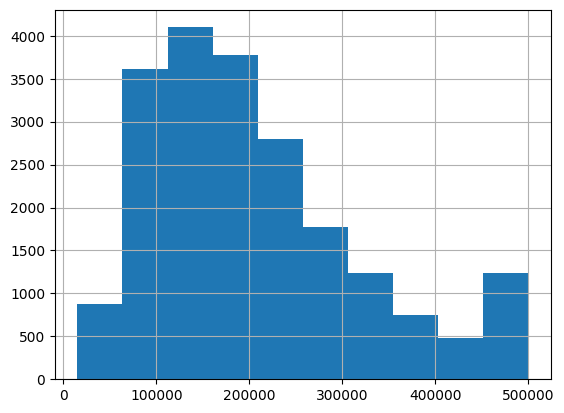

In [227]:
df.median_house_value.hist()

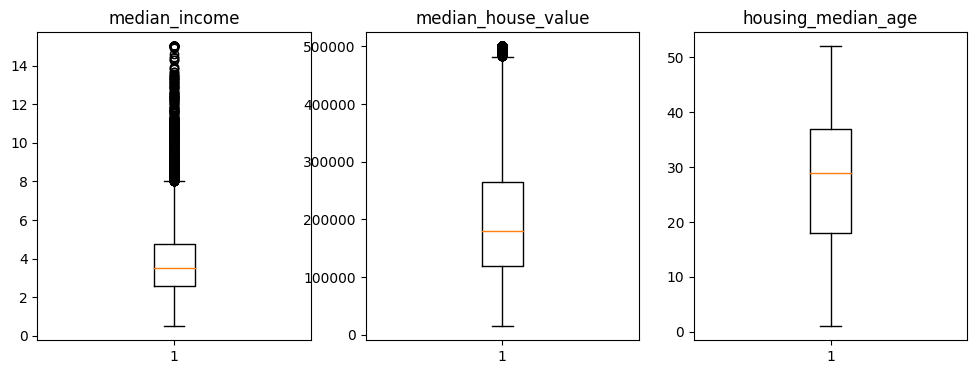

In [228]:
figure, axis = plt.subplots(1, 3, figsize=(12, 4))

col = 0
for i in df.columns:
  axis[col].boxplot(df[i])
  axis[col].set_title(i)

  col =col + 1

In [229]:
df = df[df["median_house_value"] < df["median_house_value"].quantile(0.90)]

<Axes: >

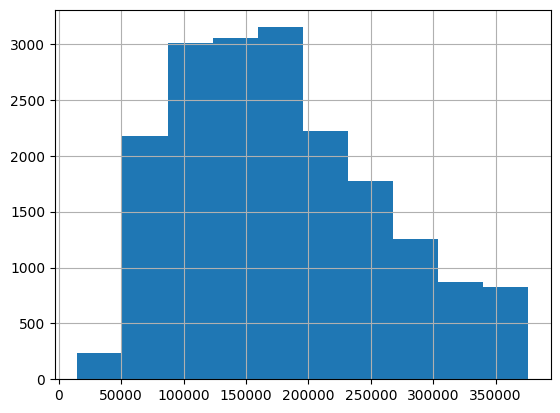

In [230]:
df.median_house_value.hist()

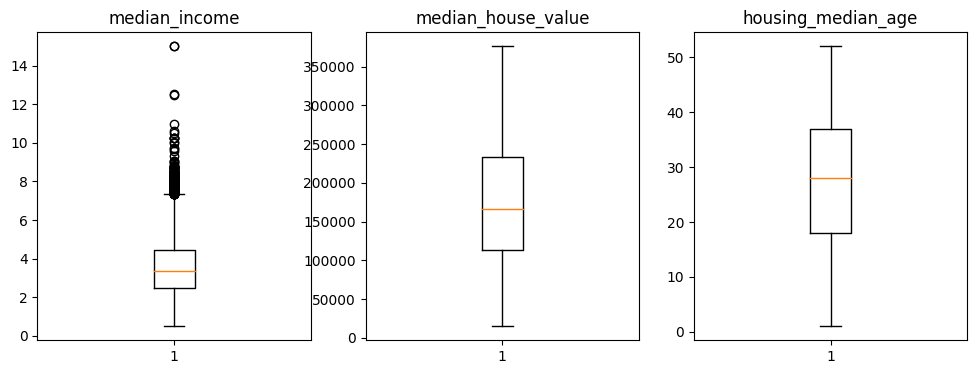

In [231]:
figure, axis = plt.subplots(1, 3, figsize=(12, 4))

col = 0
for i in df.columns:
  axis[col].boxplot(df[i])
  axis[col].set_title(i)

  col =col + 1

## División del DataSet

In [232]:
x_train, x_test, y_train, y_test = train_test_split(df.drop("median_house_value", axis = 1),
                                                                    df["median_house_value"], test_size=0.3, random_state=42)

## Aplicacion del modelo

In [233]:
#Crear objeto del modelo
dtr = DecisionTreeRegressor(random_state=0)
#Usar método fit para ajustar el modelo
reg = dtr.fit(x_train, y_train)

El score inicial del modelo se puede considerar muy bueno al ser del 98.48%. A continuación se va a modificar ciertos hiperparámetros para conseguir un modelo más ajustado a los datos.

In [234]:
reg.score(x_train, y_train)

0.9847986533330964

### Ajuste del modelo

En este punto, se decidió ajustar 4 hiperparámetros con diferentes valores.

1.   Max_depth: la máxima profundidad del árbol de decisión
2.   Min\_samples\_split: La mínima cantidad de registros para que se divida un nodo
3.   Min\_samples\_leaf: a mínima cantidad de registros que deben existir en una hoja



In [235]:
param_grid = {
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1,2,4]
}

grid_search = GridSearchCV(estimator=dtr, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(x_train, y_train)

best_params = grid_search.best_params_
print("Mejores hiperparámetros:", best_params)

Mejores hiperparámetros: {'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 10}


Al utilizar la función GridSearchCV, se pudo escoger los mejores hiperparámetros entre los valores dados en el diccionario param\_grid. Con esto, se puede realizar un nuevo entrenamiento con dichos hiperparámetros.

In [236]:
best_dtr = DecisionTreeRegressor(**best_params, random_state=42)
best_reg = best_dtr.fit(x_train, y_train)

In [237]:
y_train_pred = best_reg.predict(x_train)

print ("MAPE: ", metrics.mean_absolute_percentage_error(y_train, y_train_pred))

MAPE:  0.3146424680127532


## Predicción

En esta sección se utilizó la división del dataset destinado para probar la calidad del modelo. Posteriormente se comparó con los valores reales del dataset de prueba

La métrica a utilizar para validar la calidad del modelo es el MAPE o Mean Absolute Percentage Error en inglés. Con esta métrica de medición del error, se puede evaluar de forma porcentual el error de la predicción. Según la tabla de interpretación de esta métrica de error, un valor de MAPE entre 20 y 50%, muesta un modelo razonable, lo cual se puede observar en este caso.

In [238]:
y_pred = best_dtr.predict(x_test)

print ("MAPE: ", metrics.mean_absolute_percentage_error(y_test, y_pred))

MAPE:  0.348842904585067


En esta gráfica se puede observar como los datos reales siguen una tendencia positiva, sin embargo esta no es marcada, pues los datos se encuentran bastante dispersos. Las predicciones obtenidas siguen la misma tendencia que los valores reales y esto se puede evidenciar con el valor del MAPE de la predicción, además de que se observa cierta dispersión de los valores predecidos. Con esto, se puede concluir que el modelo de regresión lineal simple puede describir de manera aceptable los precios de las casas en California.

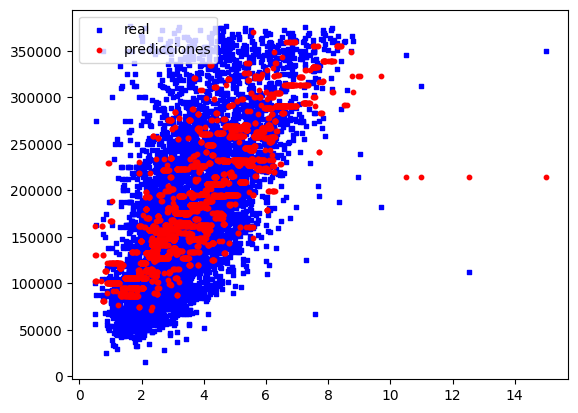

In [239]:
fig = plt.figure()
ax1 = fig.add_subplot(111)

ax1.scatter(x_test.median_income, y_test, s=10, c='b', marker="s", label='real')
ax1.scatter(x_test.median_income,y_pred, s=10, c='r', marker="o", label='predicciones')
plt.legend(loc='upper left')
plt.show()

# **PARTE 2** Análisis y Reporte sobre el desempeño del modelo

Como recapitulación, el modelo que se utilizó para solucionar este problema de regresión, fue un Árbol de decisión regresor con los siguientes hiperparámetros:


In [240]:
print("Mejores hiperparámetros:", best_params)

Mejores hiperparámetros: {'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 10}


## División del dataset

Con esta información, se procede a dividir el set de datos, ya no en entrenamiento y prueba, sino en  entrenamiento, validación y prueba, para realizar el análisis de de desempeño. A pesar de que anteriormente ya se hizo una primera división, se vuelva a separar desde cero para que el entrenamiento y validación no sean los mismos con los que se entrenó el modelo anteriormente. En este caso los subdatasets tienen el siguiente porcentaje del Dataframe original:

- Train: 60%
- Validation: 20%
- Test: 20%

In [266]:
X_train, x_test, Y_train, y_test = train_test_split(df.drop("median_house_value", axis = 1),
                                                                    df["median_house_value"], test_size=0.3, random_state=42)

x_train, x_val, y_train, y_val = train_test_split(X_train, Y_train, test_size=0.25, random_state=1) # 0.25 x 0.8 = 0.2

## Entrenamiento del modelo

In [291]:
best_reg2 = best_dtr.fit(x_train, y_train)

In [292]:
y_train_pred = best_reg2.predict(x_train)

print ("MAPE: ", metrics.mean_absolute_percentage_error(y_train, y_train_pred))

MAPE:  0.28937343332357207


## Predicción del dataset de validación

Al hacer la predicción del dataset de validación y compararlo con los valores reales, se obtiene una MAPE muy parecido al de entrenamiento, lo cual puede significar que el modelo no está sobreajustado, ya que se el error porcentual es el mismo aunque se le presentaron registros completamente nuevos.

In [293]:
y_val_pred = best_reg2.predict(x_val)
#print ("MAPE: ", metrics.mean_absolute_percentage_error(y_val, y_val_pred))
metrics.r2_score(y_val, y_val_pred)

0.3160124595460837

## Herramientas de diagnóstico

### _Sesgo_

En la gráfica de residuos, se puede observar una tendencia negativa de estos, además de que están más cargados del lado superior, lo que igual se corrobora con la sumatoria de los residuos. Esto significa que el modelo está subestimando el valor de las casas y se representa como un valor del bias medio-alto.

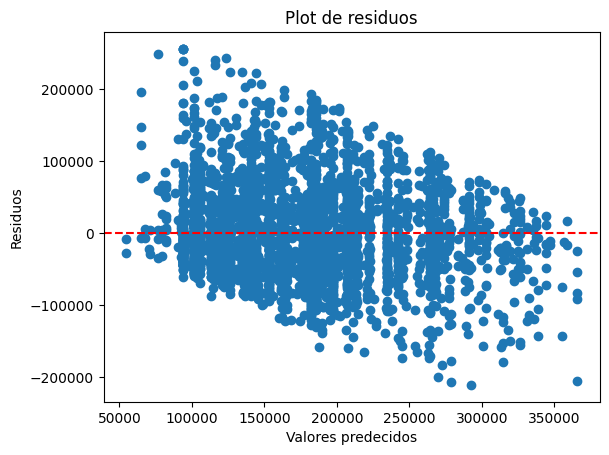

In [245]:
res = y_val - y_val_pred

# residual plot
plt.scatter(y_val_pred, res)
plt.xlabel("Valores predecidos")
plt.ylabel("Residuos")
plt.title("Plot de residuos")
plt.axhline(y=0, color='r', linestyle='--')
plt.show()

In [246]:
print ("Sumatoria de los residuos: ",sum(res))

Sumatoria de los residuos:  4946737.528375421


### _Grado de varianza_

Para poder calcular el grado de varianza del modelo, se utilizó la herramienta de Cross Validation con 4 folds en total que se aplicarían en el subset de validación. Esto permite visualizar qué tanto cambia el entrenamiento del modelo dependiendo los registros que se utilicen para entrenarlo.

El valor de la varianza es bastante pequeño y se comprueba gracias a la gráfica del MAPE para los 4 folds realizados en el Cross-Validation; esto permite comprobar que los datos son poco sensibles al uso de diferentes datasets para su entrenamiento y prueba.

In [247]:
cv_scores = cross_val_score(best_reg2, x_val, y_val, scoring='neg_mean_absolute_percentage_error', cv=4)

In [248]:
varianza = np.var(cv_scores)
print(f"Varianza de los resultados de Cross-Validation: {varianza}")

Varianza de los resultados de Cross-Validation: 0.0001204807520903329


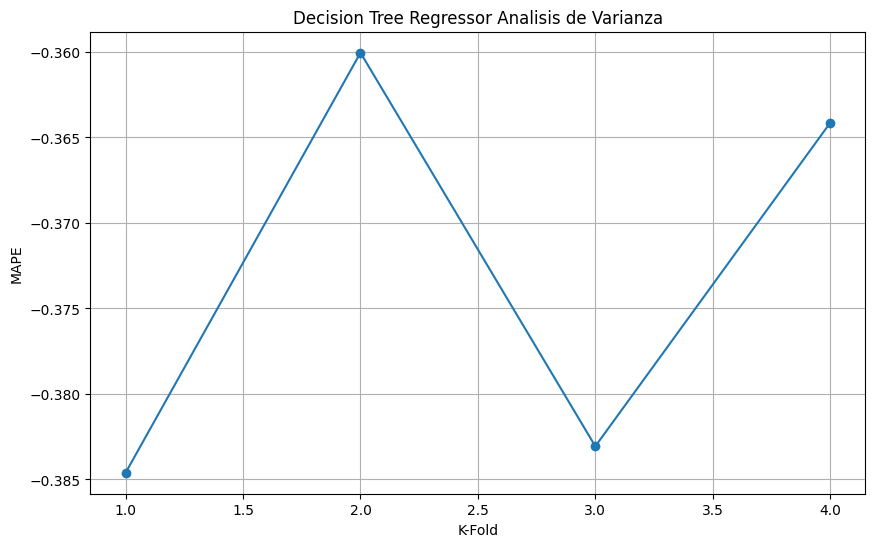

In [249]:
plt.figure(figsize=(10, 6))
plt.plot([1,2,3,4], cv_scores, marker='o', linestyle='-')
plt.title('Decision Tree Regressor Analisis de Varianza')
plt.xlabel('K-Fold')
plt.ylabel('MAPE')
plt.grid(True)
plt.show()

### _Nivel de ajuste_

En primer lugar, al comparar los valores del MAPE y la R cuadrada del modelo, ambos valores (dentro del contexto actual) pueden considerarse razonables; sin embargo, tampoco son buenos. Cuando se tienen valores bajos de estas dos métricas, significa overfitting, lo que en este caso específico podría más bien tomarse como que la diversidad de los datos es muy amplia y genera ruido en el modelo, pero no genera overfitting por lo que se ha visto en anteriores puntos, así como en la gráfica de curva de aprendizaje.

Así también, en la curva de aprendizaje, la recta de MAPE del entrenamiento crece ligeramente y luego se mantiene estable. Lo cual puede indicar que, al aumentar la cantidad de datos, también se incrementó la diversidad de los mismos y por ende el ruido incrementa ese 4% del MAPE, y cuando se estabiliza es porque el modelo ya ha podido aprender todo lo que puede de los datos sin sobreajustarse a los mismos. Mientras que la disminución y estabilización posterior de los datos de validación, muestran que existe esta generalización de los datos al ir aumentando el tamaño del subset de prueba.

Según esto, se podría decir que el modelo tiene un buen ajuste, pero que los datos atípicos están generando ruido que no permite que el modelo sea más exacto. Finalmente se decidió hacer esta limpieza de datos atípicos según el IQR y un ajuste en los hiperparámetros para así mejorar la calidad del modelo

In [250]:
mape = metrics.mean_absolute_percentage_error(y_val, y_val_pred)
r2 = metrics.r2_score(y_val, y_val_pred)

print(f"Mean Absolute Percentage Error: {mape}")
print(f"R-squared: {r2}")

Mean Absolute Percentage Error: 0.3528198840237635
R-squared: 0.3516319751163073


In [251]:
train_sizes, train_scores, val_scores = learning_curve(
    best_reg2, X_train, Y_train, cv=4, scoring='neg_mean_absolute_percentage_error')

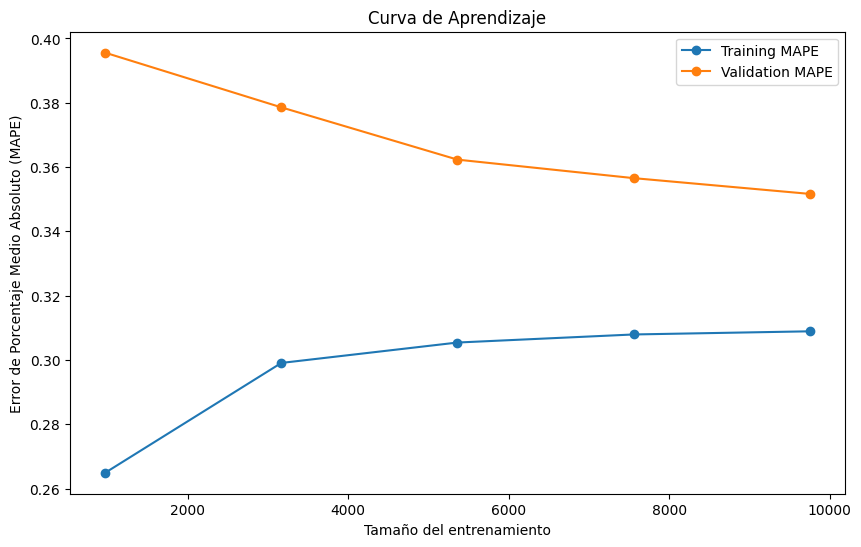

In [252]:
train_mape_mean = -np.mean(train_scores, axis=1)
val_mape_mean = -np.mean(val_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mape_mean, label='Training MAPE', marker='o')
plt.plot(train_sizes, val_mape_mean, label='Validation MAPE', marker='o')
plt.xlabel("Tamaño del entrenamiento")
plt.ylabel("Error de Porcentaje Medio Absoluto (MAPE)")
plt.title("Curva de Aprendizaje")
plt.legend()
plt.show()

## Reajuste del modelo

### Eliminación de datos atípicos

Para este caso, se vuelve a tomar la base de datos desde cero, para hacer una limpieza de datos atípicos con un menor percentil al utilizado anteriormente (90). Es importante recalcar que, debido a que los datos están sesgados hacia la derecha, solamente se eliminarán los outliers del lado derecho de la cola.

17544

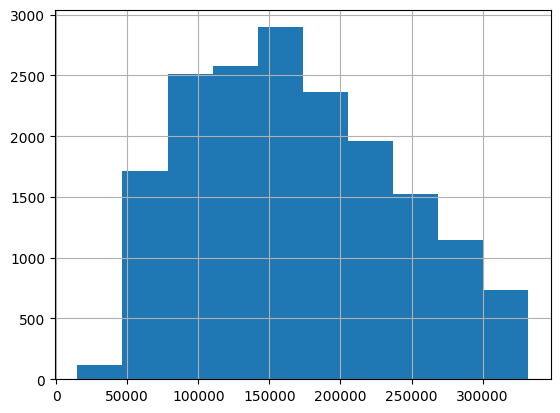

In [278]:
df = pd.read_csv("housing.csv")
df = df[['median_income', 'median_house_value', 'housing_median_age']]
df = df[df["median_house_value"] < df["median_house_value"].quantile(0.85)]
df.median_house_value.hist()
len(df)

Como se puede observar, los datos se encuentran más cercanos a una distribución normal que antes, lo que ayudará a que el modelo sea más exacto. A continuación se divide el dataset en entrenamiento, evaluación y prueba; considerando el tamaño del subset de validación según la curva de aprendizaje generada anteriormente.

In [279]:
X_train, x_test, Y_train, y_test = train_test_split(df.drop("median_house_value", axis = 1),
                                                                    df["median_house_value"], test_size=0.3, random_state=42)

print("Porcentaje de datos para el subset de evaluacion", 100-(8000/len(X_train)*100), "%")

Porcentaje de datos para el subset de evaluacion 34.85342019543974 %


In [280]:
x_train, x_val, y_train, y_val = train_test_split(X_train, Y_train, test_size=0.34, random_state=1)

### Entrenamiento y reajuste de hiperparámetros

A continuación se procede a encontrar los mejores parámetros, bajo una lista de opciones más amplia para cada hiperparámetro. Con esta información se puede continuar nuevamente a la evaluación del modelo y finalmente la aplicación al subset de prueba.

In [281]:
param_grid = {
    'max_depth': range(1, 31, 2),
    'min_samples_split': range(2, 60, 5),
    'min_samples_leaf':  range(2, 30, 5)
}

grid_search = GridSearchCV(estimator=dtr, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(x_train, y_train)

best_params = grid_search.best_params_
print("Mejores hiperparámetros:", best_params)

Mejores hiperparámetros: {'max_depth': 5, 'min_samples_leaf': 22, 'min_samples_split': 2}


In [282]:
best_dtr3 = DecisionTreeRegressor(**best_params, random_state=42)
best_reg3 = best_dtr3.fit(x_train, y_train)

Como se puede observar, el valor del error absoluto porcentual se mantuvo, mientras que el MAPE de los datos de validación y entrenamiento aumentaron aproximadamente en un 5% al anterior modelo y además son muy parecidos entre sí.

In [283]:
y_train_pred = best_reg3.predict(x_train)
y_val_pred = best_reg3.predict(x_val)

r2train = metrics.r2_score(y_train, y_train_pred)
r2val = metrics.r2_score(y_val, y_val_pred)


print ("MAPE train: ", metrics.mean_absolute_percentage_error(y_train, y_train_pred))
print(f"R-squared train: {r2train}")

print ("MAPE validation: ", metrics.mean_absolute_percentage_error(y_val, y_val_pred))
print(f"R-squared validation: {r2val}")

MAPE train:  0.32277628078161136
R-squared train: 0.419883703139597
MAPE validation:  0.33639405641951214
R-squared validation: 0.39422404681100076


### Herramientas de diagnostico


### _Sesgo_

En la gráfica de residuos, a diferencia de la anterior, se puede observar que los datos están un poco más cargados a residuios negativos; sin embargo se sigue mostrando un tendencia y por ende en una sección de los datos subestima el precio de las casas, mientras que mayor sea su precio, las sobreestima.

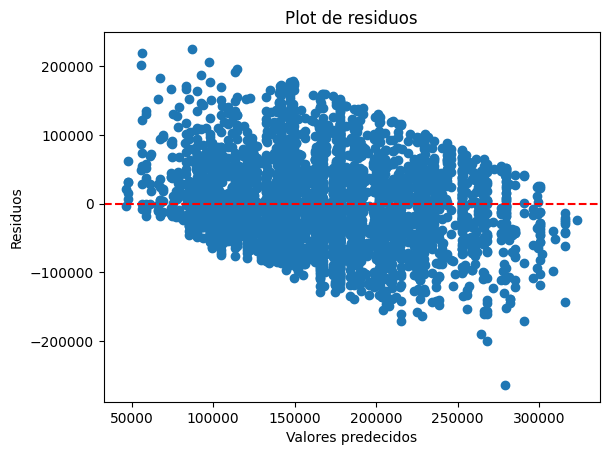

In [294]:
res = y_val - y_val_pred

# residual plot
plt.scatter(y_val_pred, res)
plt.xlabel("Valores predecidos")
plt.ylabel("Residuos")
plt.title("Plot de residuos")
plt.axhline(y=0, color='r', linestyle='--')
plt.show()

In [285]:
print ("Sumatoria de los residuos: ",sum(res))

Sumatoria de los residuos:  -4099218.2508940636


### _Grado de varianza_

Se llevó el mismo proceso que para el anterior modelo; en este caso, la varianza tiene un valor mucho más pequeño, lo que significa una menor sensibilidad al cambio de datasets de entrenamiento.

In [286]:
cv_scores = cross_val_score(best_reg3, x_val, y_val, scoring='neg_mean_absolute_percentage_error', cv=4)

In [287]:
varianza = np.var(cv_scores)
print(f"Varianza de los resultados de Cross-Validation: {varianza}")

Varianza de los resultados de Cross-Validation: 1.53231992615991e-05


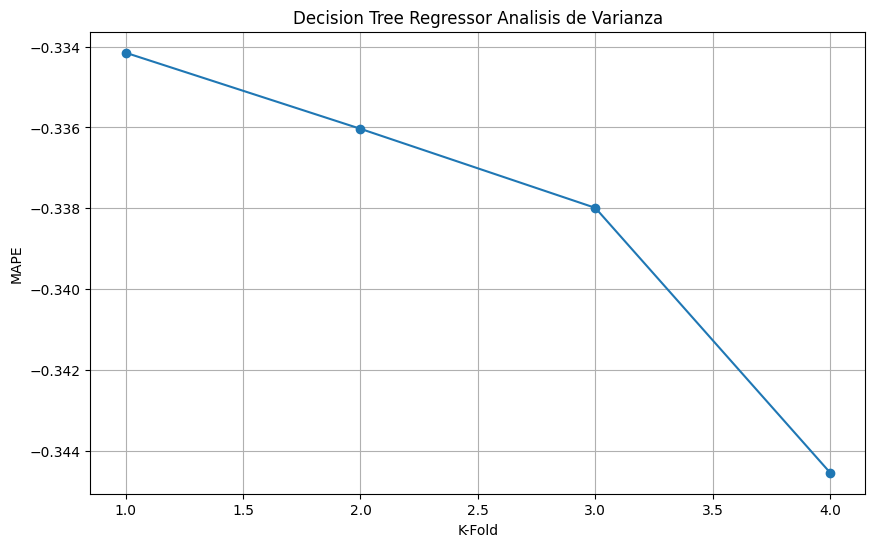

In [288]:
plt.figure(figsize=(10, 6))
plt.plot([1,2,3,4], cv_scores, marker='o', linestyle='-')
plt.title('Decision Tree Regressor Analisis de Varianza')
plt.xlabel('K-Fold')
plt.ylabel('MAPE')
plt.grid(True)
plt.show()

### Visualización de resultados

Finalmente, se aplica la predicción a los datos de prueba, donde se puede obtener un error porcentual absoluto de 0.28, lo cual es aceptable, y una R cuadrada de 0.41, lo cual para un modelo con datos tan dispersos, se puede considerar como aceptable. Es importante mencionar que, para mejorar aún más este modelo, se podría considerar un análisis previo de todas las variables del dataset y considerar el número de variables a utilizar en el DTR.

In [297]:
y_test_pred = best_reg3.predict(x_test)
r2test = metrics.r2_score(y_train, y_train_pred)


print ("MAPE train: ", metrics.mean_absolute_percentage_error(y_train, y_train_pred))
print(f"R-squared train: {r2train}")

MAPE train:  0.28937343332357207
R-squared train: 0.419883703139597


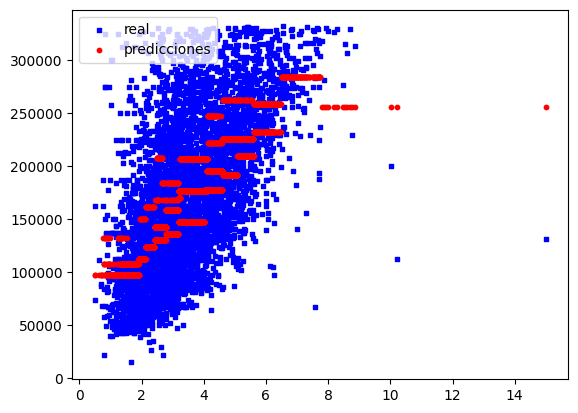

In [298]:
fig = plt.figure()
ax1 = fig.add_subplot(111)

ax1.scatter(x_test.median_income, y_test, s=10, c='b', marker="s", label='real')
ax1.scatter(x_test.median_income,y_test_pred, s=10, c='r', marker="o", label='predicciones')
plt.legend(loc='upper left')
plt.show()